In [1]:
import argparse
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

In [29]:
### load data
# from data_loader import DataLoader

folder_path = "/gpfs/milgram/scratch/turk-browne/elb77/Avatar/derivatives/pipeline3/sub-01"
roi_nii_path = os.path.join(folder_path, f'navigation_native_labeled_cluster_sizes.nii.gz')

# nii_files = [
#     'sub-01_ses-01_run-01_task-viewing.nii.gz',
#     'sub-01_ses-01_run-02_task-viewing.nii.gz',
#     'sub-01_ses-01_run-03_task-viewing.nii.gz',
#     'sub-01_ses-01_run-04_task-viewing.nii.gz',
#     'sub-01_ses-01_run-05_task-viewing.nii.gz',
#     'sub-01_ses-01_run-06_task-viewing.nii.gz',
#     'sub-01_ses-01_run-07_task-viewing.nii.gz',
#     'sub-01_ses-01_run-08_task-viewing.nii.gz',
# ]

nii_files = glob.glob(f"{folder_path}/*task-viewing.nii.gz")
nii_files.sort()

loader = DataLoader(voxel_nii_files=nii_files, roi_nii_path=roi_nii_path)

cluster_labels = loader.get_cluster_labels()
print(f"Cluster Labels: {cluster_labels}")

Cluster Labels: [ 120  138  153  163  201  283  595  645  894 3026]


In [30]:
nii_files

['/gpfs/milgram/scratch/turk-browne/elb77/Avatar/derivatives/pipeline3/sub-01/sub-01_ses-01_run-01_task-viewing.nii.gz',
 '/gpfs/milgram/scratch/turk-browne/elb77/Avatar/derivatives/pipeline3/sub-01/sub-01_ses-01_run-02_task-viewing.nii.gz',
 '/gpfs/milgram/scratch/turk-browne/elb77/Avatar/derivatives/pipeline3/sub-01/sub-01_ses-01_run-03_task-viewing.nii.gz',
 '/gpfs/milgram/scratch/turk-browne/elb77/Avatar/derivatives/pipeline3/sub-01/sub-01_ses-01_run-04_task-viewing.nii.gz',
 '/gpfs/milgram/scratch/turk-browne/elb77/Avatar/derivatives/pipeline3/sub-01/sub-01_ses-01_run-05_task-viewing.nii.gz',
 '/gpfs/milgram/scratch/turk-browne/elb77/Avatar/derivatives/pipeline3/sub-01/sub-01_ses-01_run-06_task-viewing.nii.gz',
 '/gpfs/milgram/scratch/turk-browne/elb77/Avatar/derivatives/pipeline3/sub-01/sub-01_ses-01_run-07_task-viewing.nii.gz',
 '/gpfs/milgram/scratch/turk-browne/elb77/Avatar/derivatives/pipeline3/sub-01/sub-01_ses-01_run-08_task-viewing.nii.gz']

In [33]:
n_prev_states = 2
cluster_id = 595

dataset_file = f"data__cluster-{cluster_id}_prevstates-{n_prev_states}.npy"
save_data = False

try:
    print(f"Try loading dataset from existing file: {dataset_file}")

    with open(dataset_file, 'rb') as f:
        dataset = np.load(f)

    print("Loaded dataset from existing file")

except FileNotFoundError:
    print("No existing file found")
    nii_file_paths = [os.path.join(folder_path, f) for f in nii_files]

    dataset_file = loader.get_state_dataset2(cluster_id=cluster_id, n_prev_states=n_prev_states, 
                                            run_ids=True, do_pca=True)

    print(f"Created dataset of size: {dataset_file.shape}")

    if save_data:
        with open(dataset_file, 'wb') as f:
            np.save(f, dataset)

Try loading dataset from existing file: data__cluster-595_prevstates-2.npy
No existing file found
loading data from /gpfs/milgram/scratch/turk-browne/elb77/Avatar/derivatives/pipeline3/sub-01/sub-01_ses-01_run-01_task-viewing.nii.gz...
(173, 595)
[0, 173]
[1]
1
173
loading data from /gpfs/milgram/scratch/turk-browne/elb77/Avatar/derivatives/pipeline3/sub-01/sub-01_ses-01_run-02_task-viewing.nii.gz...
(197, 595)
[0, 173, 370]
[1, 2]
2
370
loading data from /gpfs/milgram/scratch/turk-browne/elb77/Avatar/derivatives/pipeline3/sub-01/sub-01_ses-01_run-03_task-viewing.nii.gz...
(189, 595)
[0, 173, 370, 559]
[1, 2, 3]
3
559
loading data from /gpfs/milgram/scratch/turk-browne/elb77/Avatar/derivatives/pipeline3/sub-01/sub-01_ses-01_run-04_task-viewing.nii.gz...
(243, 595)
[0, 173, 370, 559, 802]
[1, 2, 3, 4]
4
802
loading data from /gpfs/milgram/scratch/turk-browne/elb77/Avatar/derivatives/pipeline3/sub-01/sub-01_ses-01_run-05_task-viewing.nii.gz...
(192, 595)
[0, 173, 370, 559, 802, 994]
[1, 

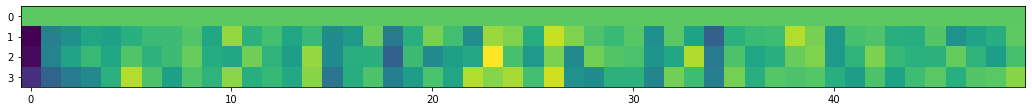

In [34]:
plt.figure(figsize=(18, 20))
plt.imshow(dataset_file[4,:, :])

In [35]:
# extract run id
# split dataset into input and target data
data_prev_states = []
data_targets = []
run_ids = []
for example in dataset_file:
    run_id = example[0,0]
    run_ids.append(run_id)
    
    prev_states = example[1:-1,:]
    data_prev_states.append(prev_states)
    
    target = example[-1,:]
    data_targets.append(target)

run_ids = np.array(run_ids)
data_prev_states = np.array(data_prev_states)
data_targets = np.array(data_targets)

In [36]:
n_examples = data_prev_states.shape[0]
n_prev_states = data_prev_states.shape[1]
n_voxels = data_prev_states.shape[2]

print(f' Number of examples in dataset {n_examples}') 
print(f' Number of previous states: {n_prev_states}')
print(f' Number of Voxel per State: {n_voxels}')

 Number of examples in dataset 1693
 Number of previous states: 2
 Number of Voxel per State: 50


### train and test data separation

In [37]:
# split dataset into train set and test set

dataset = dataset_file[:, 1:, :]

from sklearn.model_selection import train_test_split


def leave_out_run(test_id, run_ids, dataset):
    mask = (run_ids == test_id)
    trainset = dataset[~mask]
    testset = dataset[mask]
    return trainset, testset


# trainset, testset = train_test_split(dataset, test_size=0.2)

test_run = 8.0
trainset, testset = leave_out_run(test_run, run_ids, dataset)
trainset_prev, testset_prev = leave_out_run(test_run, run_ids, data_prev_states)

print(trainset.shape)
print(testset.shape)

(1476, 3, 50)
(217, 3, 50)


### NETWORK IMPLEMENTATION

In [75]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils

In [76]:
input_dim = n_prev_states * n_voxels
output_dim = n_voxels
print(f'Input Dim: {input_dim} -- Output Dim: {output_dim}')

# Number of workers for dataloader
workers = 1

# Batch size during training
batch_size = 64
# Number of training epochs
num_epochs = 30
# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
n_gpu = 0

Input Dim: 100 -- Output Dim: 50


In [77]:
# Create the dataloader
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=workers)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [78]:
class Network(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Network, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden1 = 128
        self.hidden2 = 128
        self.hidden3 = 128
        self.hidden4 = 128
        self.hidden5 = 30
        self.hidden6 = 30
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, self.hidden1),
            nn.LeakyReLU(),
            nn.Linear(self.hidden1, self.hidden2),
            nn.LeakyReLU(),
            nn.Linear(self.hidden2, self.hidden3),
            nn.LeakyReLU(),
            nn.Linear(self.hidden3, output_dim),
        )
        
#         self.model = nn.Sequential(
#             nn.Linear(input_dim, self.hidden1),
#             nn.LeakyReLU(),
#             nn.Linear(self.hidden1, self.hidden2),
#             nn.LeakyReLU(),
#             nn.Linear(self.hidden2, self.hidden3),
#             nn.LeakyReLU(),
#             nn.Linear(self.hidden3, self.hidden4),
#             nn.LeakyReLU(),
#             nn.Linear(self.hidden4, output_dim),
#         )

    def forward(self, x):
        return self.model(x)

In [79]:
net = Network(input_dim, output_dim).to(device)

# Print the model
print(net)

Network(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=50, bias=True)
  )
)


In [80]:
criterion = nn.MSELoss()

# Setup Adam optimizers
optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta1, 0.999))

In [81]:
# for idx, batch in enumerate(train_loader):
#     # Format batch
#     prev_states = torch.flatten(batch[:, :-1, :], start_dim=1).to(device)
#     targets = batch[:, -1, :].to(device)
#     print(prev_states.shape)
#     print(targets.shape)

len(test_loader.dataset)

217

In [82]:
train_losses = []
test_losses = []

def get_model_performance(epoch):
    net.eval()
    with torch.no_grad():
        sum_err_train = 0
        for idx, batch in enumerate(train_loader):
            # Format batch
            prev_states = torch.flatten(batch[:, :-1, :].float(), start_dim=1).to(device)
            targets = batch[:, -1, :].to(device)
            # Forward pass
            output = net(prev_states)
            err = criterion(output, targets).item()
            sum_err_train += err
        
        train_mse = sum_err_train / len(train_loader.dataset)
        train_losses.append(train_mse)
        
        sum_err_test = 0
        for idx, batch in enumerate(test_loader):
            # Format batch
            prev_states = torch.flatten(batch[:, :-1, :].float(), start_dim=1).to(device)
            targets = batch[:, -1, :].to(device)
            # Forward pass
            output = net(prev_states)
            err = criterion(output, targets).item()
            sum_err_test += err
            
        test_mse = sum_err_test / len(test_loader.dataset)
        test_losses.append(test_mse)
    
#     print(sum_err_train)
#     print(sum_err_test)
    print(f'EPOCH {epoch} -- Average Train MSE: {round(train_mse, 4)} -- Average Test MSE: {round(test_mse, 4)}')
    net.train()

# Training Loop
def train():
    print("Starting Training Loop...")
    
    # Lists to keep track of progress
    losses = []

    # For each epoch
    get_model_performance(0)
    
    for epoch in range(1, num_epochs+1):
        net.train()
        
        # For each batch in the dataloader
        for idx, batch in enumerate(train_loader):

            # Format batch
            prev_states = torch.flatten(batch[:, :-1, :].float(), start_dim=1).to(device)
            targets = batch[:, -1, :].float().to(device)
            
            # Forward pass
            output = net(prev_states)

            net.zero_grad()
            # Calculate networks's loss based on targets
            err = criterion(output, targets)
            # Calculate gradients for network
            err.backward()
        
            # Update G
            optimizer.step()
            
        get_model_performance(epoch)
    
    return



In [83]:
train()

Starting Training Loop...
EPOCH 0 -- Average Train MSE: 0.0807 -- Average Test MSE: 0.0879
EPOCH 1 -- Average Train MSE: 0.0802 -- Average Test MSE: 0.0888
EPOCH 2 -- Average Train MSE: 0.0773 -- Average Test MSE: 0.0879
EPOCH 3 -- Average Train MSE: 0.0737 -- Average Test MSE: 0.0831
EPOCH 4 -- Average Train MSE: 0.0693 -- Average Test MSE: 0.0801
EPOCH 5 -- Average Train MSE: 0.0656 -- Average Test MSE: 0.0792
EPOCH 6 -- Average Train MSE: 0.0609 -- Average Test MSE: 0.0778
EPOCH 7 -- Average Train MSE: 0.0588 -- Average Test MSE: 0.0721
EPOCH 8 -- Average Train MSE: 0.0571 -- Average Test MSE: 0.0715
EPOCH 9 -- Average Train MSE: 0.0541 -- Average Test MSE: 0.0702
EPOCH 10 -- Average Train MSE: 0.0534 -- Average Test MSE: 0.0696
EPOCH 11 -- Average Train MSE: 0.0514 -- Average Test MSE: 0.0676
EPOCH 12 -- Average Train MSE: 0.0506 -- Average Test MSE: 0.0675
EPOCH 13 -- Average Train MSE: 0.0496 -- Average Test MSE: 0.0683
EPOCH 14 -- Average Train MSE: 0.049 -- Average Test MSE: 0.

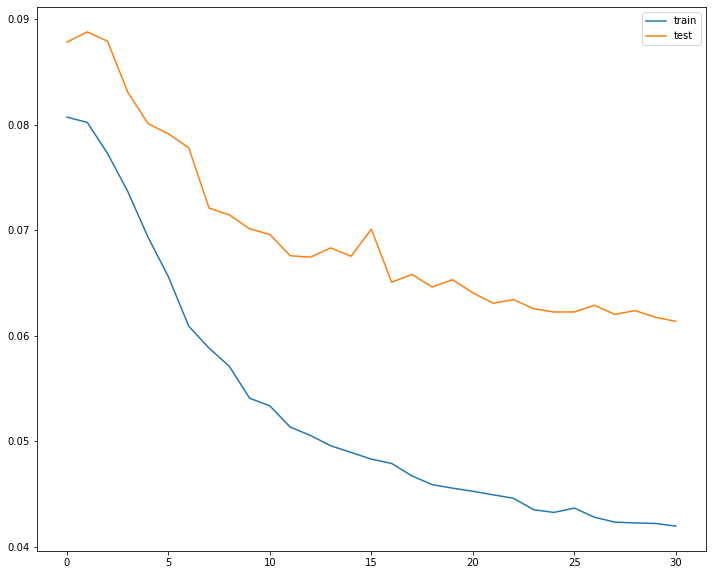

In [84]:
epochs = range(len(train_losses))
plt.figure(figsize=(12,10))
plt.plot(epochs, train_losses, label='train')
plt.plot(epochs, test_losses, label='test')
plt.legend()

# Result Analysis

## Compare real data and generated samples of random individual timepoints

Compare the real and generated activations at the same timepoint

In [85]:
# # run 5 random samples through network
# test_loader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=True, num_workers=workers)
# real_batch = next(iter(test_loader))

# prev_states = torch.flatten(real_batch[:, :-1, :], start_dim=1).float().to(device)
# targets = real_batch[:, -1, :].float().to(device)
# generated = net(prev_states).detach()

# np_prev = prev_states.numpy()
# np_targets = targets.numpy()
# np_generated = generated.numpy()

In [86]:
# def compare_activities(voxels1, voxels2):
#     width = 0.5
#     x1 = [x - width/2 for x in list(range(len(voxels1)))]
#     x2 = [x + width/2 for x in list(range(len(voxels2)))]
    
#     fig = plt.figure(figsize=(16,14))
#     ax = plt.subplot(111)
    
#     for voxels, x, col in zip([voxels1, voxels2], [x1, x2], ['r','g']):
#         negative = voxels < 0
#         positive = voxels > 0
        
#         pos = np.copy(voxels)
#         pos[positive] = 0
#         neg = np.copy(voxels)
#         neg[negative] = 0
        
#         ax.bar(x, neg, width=width, color=col)
#         ax.bar(x, pos, width=width, color=col)
        
#     plt.show()

In [87]:
# from sklearn.metrics import mean_squared_error as mse

# X = range(output_dim)

# for prev, target, gen in zip(np_prev, np_targets, np_generated):
#     print("===== NEW SAMPLE =====")
    
#     plt.figure(figsize=(20,18))
#     plt.title('previous states')
#     plt.imshow(prev.reshape((2,50)))
#     ax = plt.gca()
#     ax.axes.yaxis.set_visible(False)
    
#     plt.figure(figsize=(20,18))
#     plt.title('target')
#     plt.imshow(target.reshape((1,50)))
#     ax = plt.gca()
#     ax.axes.yaxis.set_visible(False)
    
#     plt.figure(figsize=(20,18))
#     plt.title('generated sample')
#     plt.imshow(gen.reshape((1,50)))
#     ax = plt.gca()
#     ax.axes.yaxis.set_visible(False)
#     plt.show()
    
#     compare_activities(target, gen)
    
#     print(f'MSE: {mse(gen, target)}')

## Compare all timepoints in test run

### Ground Truth

In [88]:
_, run_targets = leave_out_run(test_run, run_ids, data_targets)
run_targets.shape

(217, 50)

### Predicition Option 1: Given previous two real timepoints (t-2, t-1), predict timestep t

In [89]:
test_loader = torch.utils.data.DataLoader(testset, batch_size=testset.shape[0], shuffle=False, num_workers=workers)
batch = next(iter(test_loader))

prev_states = torch.flatten(batch[:, :-1, :], start_dim=1).float().to(device)
targets = batch[:, -1, :].float().to(device)
predictions = net(prev_states).detach()

pred_1 = predictions.numpy()

### Prediction Option 2: Feed predictions back as new input

In [90]:
results = []

# start with first two real timepoints
prev_2 = testset[0, 0, :]
prev_1 = testset[0, 1, :]

for i in range(testset.shape[0]):
    # last two predicted timesteps == new input 
    np_in = np.concatenate((prev_2, prev_1))
    torch_in = torch.from_numpy(np_in[:])
    
    # predict timestep t
    prediction = net(torch_in.float()).detach()
    np_pred = prediction.numpy()
    
    results.append(np_pred[np.newaxis,:])
    
    # update previous
    prev_2 = prev_1
    prev_1 = np_pred
    

pred_2 = np.concatenate(tuple(results), axis=0)

### 0. Metrics

In [91]:
from sklearn.metrics import mean_squared_error
mean_squared_error(run_targets, pred_1)

3.3820950795161338

In [92]:
from sklearn.metrics.pairwise import cosine_similarity

_, prev_frames = leave_out_run(test_run, run_ids, data_prev_states)

prev_t = prev_frames[:, 1, :]

vecs_real = run_targets - prev_t
vecs_pred = pred_1 - prev_t

# for i in range(vecs_pred.shape[0]):
#     print(cosine_similarity(vecs_real[i].reshape(1, -1), vecs_pred[i].reshape(1, -1)))
    
cos_sims = []
for i in range(vecs_pred.shape[0]):
    cos_sim = cosine_similarity(vecs_real[i].reshape(1, -1), vecs_pred[i].reshape(1, -1))
    cos_sims.append(cos_sim)
    
np.mean(np.array(cos_sims))

0.49817737567588194

### 1. Compare PHATE-embeddings of real data and generated samples

In [56]:
import sklearn.decomposition # PCA
import sklearn.manifold # t-SNE
import phate

In [57]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

def phate_2d(arr_2d):
    plt.figure(figsize=(12,10))
    plt.scatter(arr_2d[:,0], arr_2d[:,1], c=list(range(Y_phate.shape[0])), cmap='viridis', vmin=0, vmax=Y_phate.shape[0])
    plt.colorbar()
    plt.show()
    
def phate_3d(arr_3d, rotation=0):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111, projection='3d')
    plot = ax.scatter(arr_3d[:,0], arr_3d[:,1], arr_3d[:,2], c=list(range(Y_phate.shape[0])), cmap='viridis', vmin=0, vmax=Y_phate.shape[0])

    ax.view_init(30, rotation)
    plt.colorbar(plot)
    plt.show()

### phate-embedding real data

In [62]:
# phate_operator = phate.PHATE()
# Y_phate = phate_operator.fit_transform(run8_targets)

In [63]:
# phate_2d(Y_phate)

In [64]:
# phate_operator.set_params(n_components=3)
# Y_phate_3d = phate_operator.transform()

In [65]:
# phate_3d(Y_phate_3d, rotation=30)

### phate-embedding prediction version 1

In [66]:
# Y_phate2 = phate_operator.fit_transform(pred_1)
# phate_2d(Y_phate2)

In [67]:
# phate_operator.set_params(n_components=3)
# Y_phate2_3d = phate_operator.transform()
# phate_3d(Y_phate2_3d, rotation=30)

### phate embedding prediction version 2

In [68]:
# Y_phate3 = phate_operator.fit_transform(pred_2)
# phate_2d(Y_phate3)

In [69]:
# phate_operator.set_params(n_components=3)
# Y_phate3_3d = phate_operator.transform()
# phate_3d(Y_phate3_3d, rotation=30)

### all versions embedded together

In [60]:
print(run_targets.shape)
print(pred_1.shape)
print(pred_2.shape)

(217, 50)
(217, 50)
(217, 50)


In [61]:
run_all = np.concatenate((run_targets, pred_1, pred_2))

In [62]:
run_all.shape

(651, 50)

In [63]:
phate_operator = phate.PHATE()
Y_phate = phate_operator.fit_transform(run_all)

Calculating PHATE...
  Running PHATE on 651 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.07 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 0.12 seconds.
  Calculating optimal t...
    Automatically selected t = 20
  Calculated optimal t in 0.65 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.51 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.32 seconds.
Calculated PHATE in 1.61 seconds.


In [65]:
t_run = run_targets.shape[0]
phate_1 = Y_phate[:t_run, :]
phate_2 = Y_phate[t_run:2*t_run, :]
phate_3 = Y_phate[2*t_run:, :]

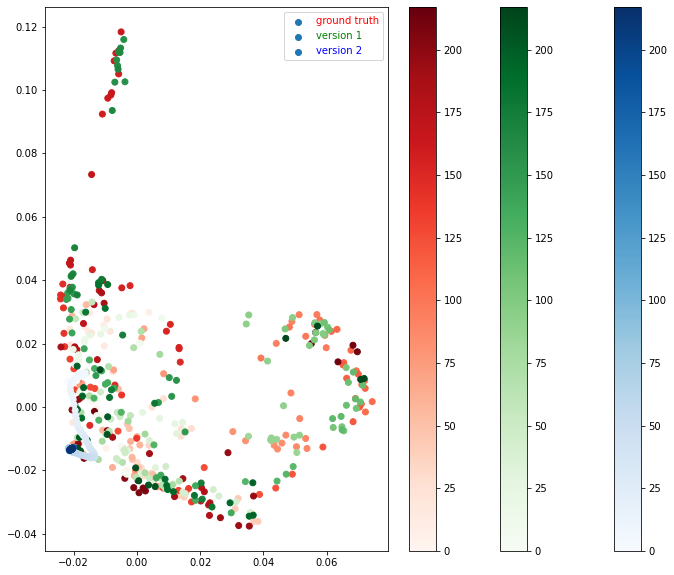

In [66]:
plt.figure(figsize=(12,10))

plot1 = plt.scatter(phate_1[:,0], phate_1[:,1], 
                    c=list(range(phate_1.shape[0])), cmap='Reds', vmin=0, vmax=phate_1.shape[0])
plot2 = plt.scatter(phate_2[:,0], phate_2[:,1], 
                    c=list(range(phate_2.shape[0])), cmap='Greens', vmin=0, vmax=phate_2.shape[0])
plot3 = plt.scatter(phate_3[:,0], phate_3[:,1], 
                    c=list(range(phate_3.shape[0])), cmap='Blues', vmin=0, vmax=phate_3.shape[0])

plt.colorbar(plot3)
plt.colorbar(plot2)
plt.colorbar(plot1)
plt.legend([plot1, plot2, plot3], ['ground truth', 'version 1', 'version 2'], labelcolor=['red', 'green', 'blue'])
plt.show()

3D Embeddings

In [67]:
phate_operator.set_params(n_components=3)
Y_phate3_3d = phate_operator.transform()

phate_1_3d = Y_phate3_3d[:t_run, :]
phate_2_3d = Y_phate3_3d[t_run:2*t_run, :]
phate_3_3d = Y_phate3_3d[2*t_run:, :]

Calculating metric MDS...
Calculated metric MDS in 1.77 seconds.


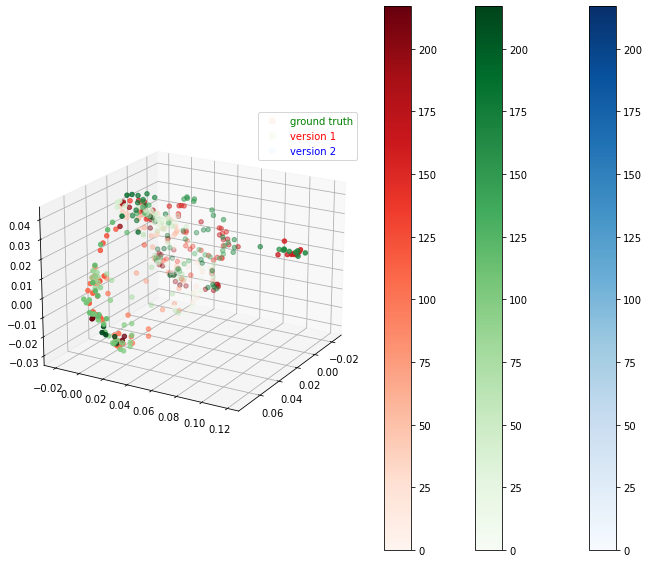

In [68]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')

plot1_3d = ax.scatter(phate_1_3d[:,0], phate_1_3d[:,1], phate_1_3d[:,2], c=list(range(phate_1_3d.shape[0])), 
                  cmap='Greens', vmin=0, vmax=phate_1_3d.shape[0])
plot2_3d = ax.scatter(phate_2_3d[:,0], phate_2_3d[:,1], phate_2_3d[:,2], c=list(range(phate_2_3d.shape[0])), 
                  cmap='Reds', vmin=0, vmax=phate_2_3d.shape[0])
# plot3_3d = ax.scatter(phate_3_3d[:,0], phate_3_3d[:,1], phate_3_3d[:,2], c=list(range(phate_3_3d.shape[0])), 
#                   cmap='Blues', vmin=0, vmax=phate_3_3d.shape[0])

ax.view_init(20, 30)

plt.colorbar(plot3)
plt.colorbar(plot2)
plt.colorbar(plot1)
ax.legend([plot1, plot2, plot3], ['ground truth', 'version 1', 'version 2'], labelcolor=['green', 'red', 'blue'])
plt.show()

### 3. Timeseries comparison

In [ ]:
from IPython.display import clear_output

def display_timeseries_2D(phate_1, phate_2):
    
    for i in range(phate_1.shape[0]):

        clear_output(wait=True)

        fig, ax = plt.subplots(figsize=(10, 8))

        real_plot = ax.scatter(phate_1[:,0], phate_1[:,1], c=list(range(phate_1.shape[0])), 
                            cmap='Greens', vmin=0, vmax=phate_1.shape[0])
        gen_plot1 = ax.scatter(phate_2[:,0], phate_2[:,1], c=list(range(phate_2.shape[0])), 
                           cmap='Reds', vmin=0, vmax=phate_2.shape[0])

        ax.plot([phate_1[i,0], phate_2[i,0]], [phate_1[i,1], phate_2[i,1]], color='cyan', lw='5.0')
        ax.plot(phate_1[i,0], phate_1[i,1], marker='o', mec='cyan', color='green', ms='12')
        ax.plot(phate_2[i,0], phate_2[i,1], marker='o', mec='cyan', color='red', ms='12')
        
        plt.title(f'Timepoint {i}')
    #     plt.show()

        fig.savefig(f"./fnn_results/pca_2d_t{i}")
        
        
def display_timeseries_3D(phate_1_3d, phate_2_3d): 
    
    for i in range(phate_1_3d.shape[0]):
        
        fig = plt.figure(figsize=(12,10))
        ax = fig.add_subplot(111, projection='3d')
        
        plot1_3d = ax.scatter(phate_1_3d[:,0], phate_1_3d[:,1], phate_1_3d[:,2], c=list(range(phate_1_3d.shape[0])), 
                          cmap='Greens', vmin=0, vmax=phate_1_3d.shape[0])
        plot2_3d = ax.scatter(phate_2_3d[:,0], phate_2_3d[:,1], phate_2_3d[:,2], c=list(range(phate_2_3d.shape[0])), 
                          cmap='Reds', vmin=0, vmax=phate_2_3d.shape[0])

        ax.plot([phate_1_3d[i,0], phate_2_3d[i,0]], [phate_1_3d[i,1], phate_2_3d[i,1]], [phate_1_3d[i,2], phate_2_3d[i,2]], color='cyan', lw='5.0')
        ax.plot(phate_1_3d[i,0], phate_1_3d[i,1], phate_1_3d[i,2], marker='o', mec='cyan', color='green', ms='12')
        ax.plot(phate_2_3d[i,0], phate_2_3d[i,1], phate_2_3d[i,2], marker='o', mec='cyan', color='red', ms='12')
        
        ax.view_init(20, 30)
        
        plt.title(f'Timepoint {i}')
        ax.legend([plot1_3d, plot2_3d], ['ground truth', 'predictions'], labelcolor=['green', 'red',])
        fig.savefig(f"./fnn_results/pca_3d_t{i}")

In [ ]:
run_all = np.concatenate((run8_targets, pred_1))

phate_operator = phate.PHATE()
Y_phate_series = phate_operator.fit_transform(run_all)

In [ ]:
t_run = run8_targets.shape[0]
phate_real = Y_phate_series[:t_run, :]
phate_pred = Y_phate_series[t_run:, :]

print(phate_real.shape)
print(phate_pred.shape)

In [ ]:
display_timeseries_2D(phate_real, phate_pred)

In [ ]:
phate_operator.set_params(n_components=3)
Y_phate_series_3d = phate_operator.transform()

phate_real_3d = Y_phate3_3d[:t_run, :]
phate_pred_3d = Y_phate3_3d[t_run:2*t_run, :]

print(phate_real_3d.shape)
print(phate_pred_3d.shape)

In [ ]:
display_timeseries_3D(phate_real_3d, phate_pred_3d)